In [1]:
import functools
import jax
import os
import html

from datetime import datetime
from jax import numpy as jp
jax.config.update("jax_debug_nans", False)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output, display

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html

import shutil

from src.pods.Pods import train as train_pods
from src.hds.Hds import train as train_hds
from src.env.Pendulum import InvertedPendulum
import pickle




In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

cpu
[CpuDevice(id=0)]


In [3]:
env = InvertedPendulum(target=jp.array([1]))
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

#HTML(html.render(env.sys, [state.pipeline_state]))

In [4]:
ckpt_dir = './tmp/flax_ckpt'

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)  # Remove any existing checkpoints from the last notebook run.

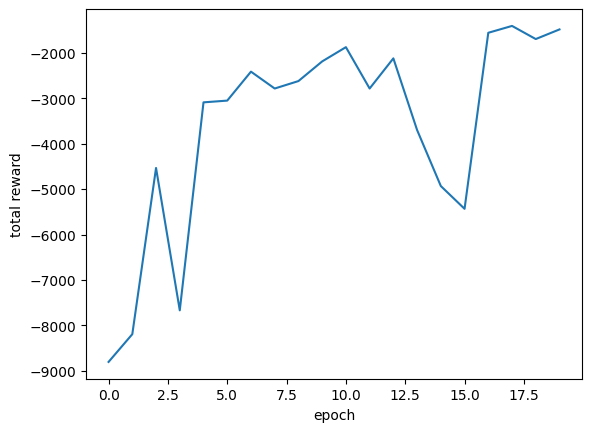

big epoch: 19 small epoch: 0 Loss 0.0001388391898839266
big epoch: 19 small epoch: 1 Loss 9.249881583996428e-05
big epoch: 19 small epoch: 2 Loss 0.0010064052048906012
big epoch: 19 small epoch: 3 Loss 9.493560349422745e-05
big epoch: 19 small epoch: 4 Loss 9.763440094095194e-05
big epoch: 19 small epoch: 5 Loss 4.182020208279427e-05
big epoch: 19 small epoch: 6 Loss 6.072447449073159e-05
big epoch: 19 small epoch: 7 Loss 5.11638761358697e-05
big epoch: 19 small epoch: 8 Loss 8.072544401580699e-05
big epoch: 19 small epoch: 9 Loss 4.917705282192873e-05
big epoch: 19 small epoch: 10 Loss 3.0494504466487368e-05
big epoch: 19 small epoch: 11 Loss 0.00020681477299300849
big epoch: 19 small epoch: 12 Loss 0.0004288271420745725
big epoch: 19 small epoch: 13 Loss 0.00012796104426951785
big epoch: 19 small epoch: 14 Loss 8.448451549305566e-05
big epoch: 19 small epoch: 15 Loss 2.7977003339545986e-05
big epoch: 19 small epoch: 16 Loss 1.0136005356460095e-05
big epoch: 19 small epoch: 17 Loss 7.

In [5]:

def progress_f(x_data,y_data,epoch,reward):
    print(reward)
    x_data.append(epoch)
    y_data.append(reward)
    clear_output(wait=True)
    plt.xlabel('epoch')
    plt.ylabel('total reward')
    plt.plot(x_data, y_data)
    plt.show()

#policy = train_hds(env,trajectory_length=100 ,num_samples=50,epochs=4, inner_epochs=20, alpha_a=1e-5, init_learning_rate=1e-3, init_noise=0.1, noise_decay=0.5, progress_fn=progress_f) 
policy = train_pods(env,trajectory_length=100 ,num_samples=50,epochs=20, inner_epochs=20, alpha_a=8e-5, init_learning_rate=1e-3, progress_fn=progress_f)

In [6]:
f = open("reward.txt", "w")
g = open("actions.txt", "w")
inference_fn = policy()
rollout = []
rng = jax.random.PRNGKey(seed=1)
state = env.reset(rng=rng)
reward = []
actions = []
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  #print(state.obs)
  act = inference_fn(state.obs)
  print(act)
  reward.append(state.reward)
  state = env.step(state, act)
  #print(state.reward)
  actions.append(act)

  
print(reward, file=f)
print(actions, file=g)

[0.99998509]
[0.99998314]
[0.99991145]
[0.99891556]
[0.99342618]
[0.94198142]
[0.41661332]
[0.40791102]
[0.40732436]
[0.4230495]
[0.41904812]
[0.40058097]
[0.36709933]
[0.31102729]
[0.23423235]
[0.18319741]
[0.18319741]
[0.18319741]
[0.18319741]
[0.17273481]
[0.06939632]
[0.03861886]
[0.03111519]
[0.05041811]
[0.07879956]
[0.13316593]
[0.17723037]
[0.18319741]
[0.18319741]
[0.18319741]
[0.18319741]
[0.18319741]
[0.1628107]
[0.10879196]
[0.09361677]
[0.08778722]
[0.09175613]
[0.11483719]
[0.14290632]
[0.16000446]
[0.172295]
[0.17552243]
[0.17208643]
[0.16307815]
[0.14936493]
[0.1318597]
[0.11016894]
[0.0866822]
[0.07215792]
[0.0633378]
[0.05317309]
[0.04991042]
[0.04754652]
[0.04622163]
[0.04544921]
[0.04519647]
[0.04520814]
[0.04545629]
[0.04592607]
[0.04663649]
[0.04752115]
[0.04842939]
[0.04910298]
[0.0496184]
[0.04995715]
[0.0500874]
[0.05018691]
[0.05020634]
[0.04985263]
[0.04923138]
[0.04837973]
[0.04732231]
[0.04609057]
[0.04472084]
[0.04325244]
[0.04181429]
[0.04035993]
[0.03892

In [7]:

yes=html.render(env.sys.replace(dt=env.dt), rollout)
with open("data.html", "w") as file:
    file.write(yes)